In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from scipy.special import gamma
warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)
os.makedirs('../models',exist_ok=True)

sns.set_theme('paper')

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# 1.Load and Explore data

In [2]:
data = pd.read_csv('../data/Heart_Disease.csv')

print('Data info:\n',data.info())

print('\nData description:\n',data.describe())

print('\nTarget value counts:\n',data['target'].value_counts())

print('\nMissing values:\n',data.isna().sum())

print('\nData shape:\t',data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB
Data info:
 None

Data description:
                age          sex  chest pain type  resting bp s  cholesterol  \
count  1190.000000  1190

# 2.Feature selection using correlation matrix

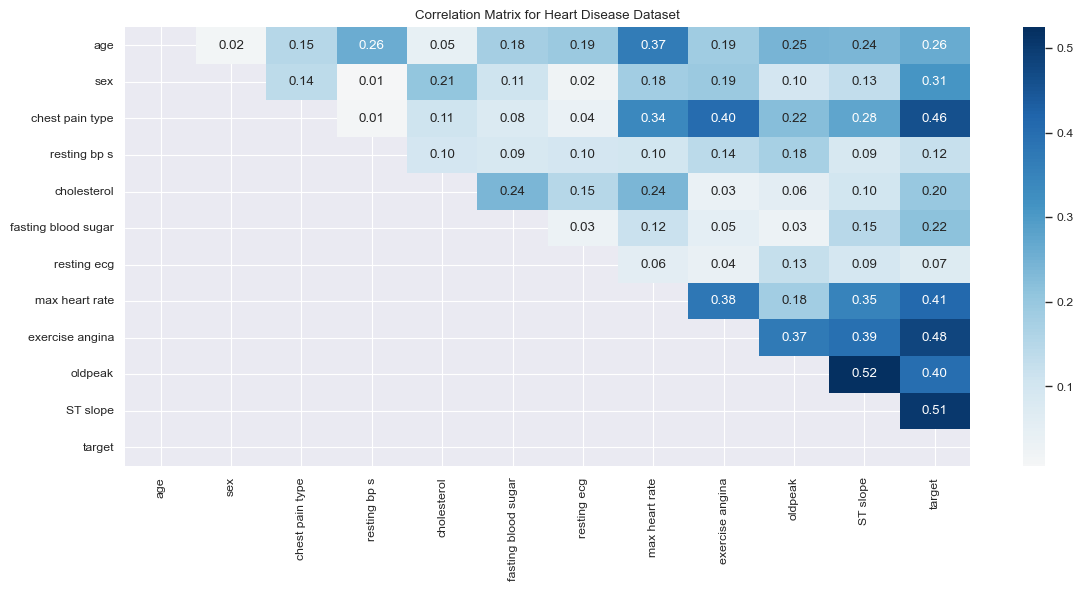

In [4]:
plt.figure(figsize=(12,6))
corr_mat = data.corr().abs()
mask = np.tril(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat, mask=mask, annot=True, cmap='RdBu', center=0, fmt='.2f')
plt.title('Correlation Matrix for Heart Disease Dataset')
plt.tight_layout()
plt.savefig('../results/correlation_matrix.png', dpi=300)
plt.show()

Drop highly correlated features if exist

In [5]:
upper_tri = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]
print(f'Features to drop due to high correlation: {to_drop}')

Features to drop due to high correlation: []


# 3. spliting the data


In [6]:
X = data.drop('target',axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# 4. train and evaluate baseline KNN model

In [8]:
sns.set_theme(style='whitegrid')
def train_evaluate_knn(X_train,X_test,y_train,y_test ,scaling=False, **kwargs):
    if scaling:
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        X_test_scaled= scaler.transform(X_test)
        print("\nRunning KNN with scaling.")
        X_train_use ,X_test_use = X_train_scaled, X_test_scaled
    else:
        print("\nRunning KNN without scaling.")
        X_train_use ,X_test_use = X_train, X_test

    knn_model = KNeighborsClassifier(**kwargs)
    knn_model.fit(X_train_use,y_train)

    y_pred = knn_model.predict(X_test_use)
    y_prob = knn_model.predict_proba(X_test_use)[:,1]

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()
    cv_auc = cross_val_score(knn_model, X_train_use, y_train, cv=5, scoring='roc_auc').mean()

    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\nAccuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")
    print(f"AUC (Test): {auc:.4f} | CV-AUC: {cv_auc:.4f}")
    
    print("\nConfusion Matrix:\n", cm)
    print("\nClassification Report:\n", clr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}.png', dpi=300)
    plt.close()

    return{
        'model':knn_model,
        'scaler':scaler if scaling else None,
        'X_train_use':X_train_use,
        'X_test_use':X_test_use,
        'Accuracy':acc,
        'F1':f1,
        'AUC': auc,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'CV_AUC': cv_auc,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

In [9]:
print("****** Results of the Baseline KNN Model ******")
result_unscaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=False)
result_scaled = train_evaluate_knn(X_train,X_test,y_train,y_test,scaling=True)

****** Results of the Baseline KNN Model ******

Running KNN without scaling.

Accuracy (Test): 0.7017 | CV: 0.7049
F1-Score (Test): 0.7280 | CV: 0.7255
AUC (Test): 0.6984 | CV-AUC: 0.7553

Confusion Matrix:
 [[72 40]
 [31 95]]

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       112
           1       0.70      0.75      0.73       126

    accuracy                           0.70       238
   macro avg       0.70      0.70      0.70       238
weighted avg       0.70      0.70      0.70       238


Running KNN with scaling.

Accuracy (Test): 0.8361 | CV: 0.8488
F1-Score (Test): 0.8494 | CV: 0.8575
AUC (Test): 0.8338 | CV-AUC: 0.9042

Confusion Matrix:
 [[ 89  23]
 [ 16 110]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.83      0.87      0.85       126

    accuracy                           0.84       

# 5. OOA Implementation (adapted from Octopus Optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [10]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin(np.pi * beta /2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * u * sigma/ (np.abs(v) ** (1/beta))

    return step

In [11]:
sns.set_theme('paper')

def ooa_optimize(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10 ):
    np.random.seed(42)
    pop = np.random.uniform(lb,ub,(N,dim))
    fitness = np.array([obj_func(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]
    history = [-best_fit]

    vr , ll = 3, 0.8

    for t in range(1,max_iter +1):
        for i in range(Nh):
            trans = (2 * np.random.rand() -1) * vr * (1-t / max_iter)
            if abs(trans) < ll:
                new_pos = pop[i] + np.random.rand() * (best_pos - pop[i]) * levy_flight(dim)
                new_pos = np.clip(new_pos,lb,ub)
                new_fit = obj_func(new_pos)
                if new_fit < fitness[i]:
                    pop[i] = new_pos
                    fitness[i] = new_fit
                    if new_fit < best_fit:
                        best_pos, best_fit = new_pos,new_fit
        
        for i in range(Nh, N):
            new_pos = pop[i] + (2 * np.random.rand(dim) - 1) * (ub - lb)  * ( 1-t / max_iter)
            new_pos = np.clip(new_pos, lb, ub)
            new_fit = obj_func(new_pos)
            if new_fit < fitness[i]:
                pop[i] = new_pos
                fitness[i] = new_fit
                if new_fit < best_fit:
                    best_pos, best_fit = new_pos, new_fit
        
        history.append(-best_fit)
        
        if t%20 ==0:
            print(f"Iter {t}: Best CV Acc ={-best_fit:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iterations')
    plt.ylabel('Fitness Value')
    plt.title(f'Fitness Evaluation during {max_iter} iterations')
    plt.savefig('../results/fitness_evaluation.png', dpi=300)
    plt.show()

    return best_pos , -best_fit

In [12]:
scaler_ooa = StandardScaler()
X_train_scaled = scaler_ooa.fit_transform(X_train)
X_test_scaled = scaler_ooa.transform(X_test)

In [13]:
# objective

metric_map = {1: 'euclidean', 2: 'manhattan', 3: 'chebyshev', 4:'Minkowski', 5:'Hamming', 6:'Cosine'}
weight_map = {1: 'uniform', 2: 'distance'}

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    metric_idx = int(np.clip(params[2], 1, 6))
    weight_idx = int(np.clip(params[3], 1, 2))

    metric = metric_map[metric_idx]
    weights = weight_map[weight_idx]

    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric=metric,weights=weights)  
    
    #cv on train for robust opt
    cv_acc = cross_val_score(knn,X_train_scaled,y_train,cv=5, scoring='accuracy').mean()

    return -(cv_acc) # min -cv acc



**** OOA Optimazation (CV based) ****
Iter 20: Best CV Acc =0.9065
Iter 40: Best CV Acc =0.9065
Iter 60: Best CV Acc =0.9065
Iter 80: Best CV Acc =0.9065


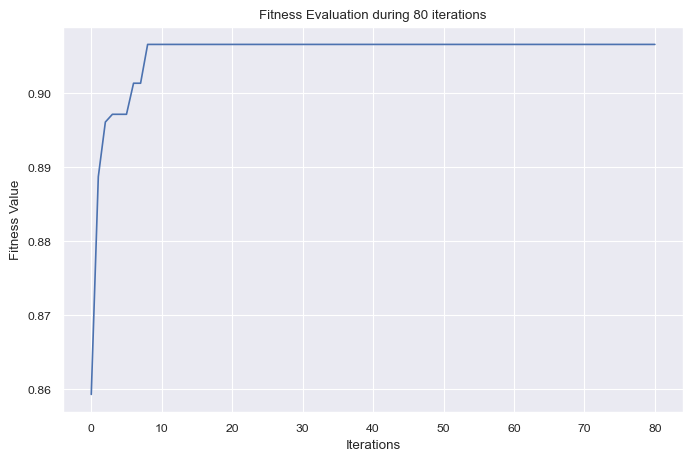


Best OOA Params : k=13, p=1.13, metric=manhattan,weights=distance
Best OOA CV Accuracy:0.9065


In [14]:
lb = np.array([1,1,1,1])
ub = np.array([30,3,3,2])
dim = 4

print("\n**** OOA Optimazation (CV based) ****")
best_params, best_cv_acc = ooa_optimize(knn_objective,lb,ub,dim,N=30,max_iter=80) 
best_k, best_p, best_metric_idx, best_weight_idx  = int(best_params[0]),best_params[1],int(best_params[2]), int(best_params[3])

best_metric = metric_map[best_metric_idx]
best_weight = weight_map[best_weight_idx]

print(f"\nBest OOA Params : k={best_k}, p={best_p:.2f}, metric={best_metric},weights={best_weight}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")

In [15]:
# eval tuned on test 

knn_opt = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric=best_metric,weights='distance')
knn_opt.fit(X_train_scaled,y_train)

y_pred_opt = knn_opt.predict(X_test_scaled)
y_prob_opt = knn_opt.predict_proba(X_test_scaled)[:,1]

acc_opt = accuracy_score(y_test,y_pred_opt)
f1_opt = f1_score(y_test,y_pred_opt)
auc_opt = roc_auc_score(y_test, y_prob_opt)

cv_acc_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='accuracy').mean()
cv_f1_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='f1').mean()
cv_auc_opt = cross_val_score(knn_opt, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()

cm_opt = confusion_matrix(y_test, y_pred_opt)
clr_opt = classification_report(y_test, y_pred_opt)

In [16]:
#overfit checker
train_acc = accuracy_score(y_train,knn_opt.predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {acc_opt:.4f} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=1.0000  vs Test= 0.9538 (Diff < 0.05 -->ok)


In [17]:
print(f"\nOOA-KNN Test Acc:{acc_opt:.4f} | CV-acc: {cv_acc_opt:.4f}")
print(f"OOA-KNN Test F1:{acc_opt:.4f} | CV-f1: {cv_f1_opt:.4f}")
print(f"OOA-KNN Test AUC: {auc_opt:.4f} | CV-AUC: {cv_auc_opt:.4f}")



OOA-KNN Test Acc:0.9538 | CV-acc: 0.9065
OOA-KNN Test F1:0.9538 | CV-f1: 0.9124
OOA-KNN Test AUC: 0.9718 | CV-AUC: 0.9556


In [18]:
print("\nOOA Confusion Matrix:\n", cm_opt)
print("\nOOA Classification Report:\n", clr_opt)


OOA Confusion Matrix:
 [[107   5]
 [  6 120]]

OOA Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       112
           1       0.96      0.95      0.96       126

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



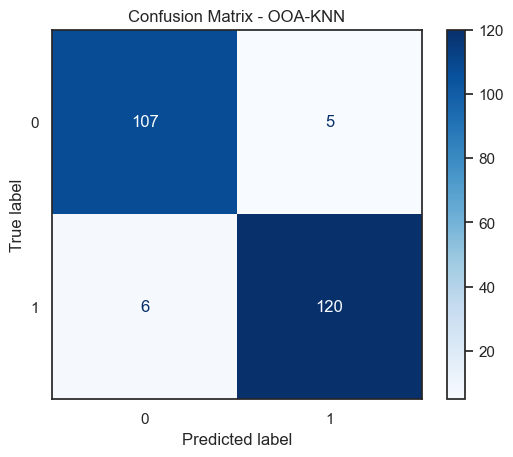

In [20]:
sns.set_theme(style='white')
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot(cmap='Blues')
plt.title('Confusion Matrix - OOA-KNN')
plt.savefig('../results/cm_ooa_knn.png', dpi=300)
plt.show()

In [21]:
#comparision table 
print("\n***** Performance Comparision ****")
comparison_data = {
    'Model': ['KNN Unscaled','KNN Scaled','OOA-KNN (Optimized)'],
    'Test Acc': [result_unscaled['Accuracy'], result_scaled['Accuracy'], acc_opt],
    'Test F1': [result_unscaled['F1'], result_scaled['F1'], f1_opt],
    'Test AUC':[result_unscaled['AUC'], result_scaled['AUC'], auc_opt],
    'CV Acc': [result_unscaled['CV_Acc'], result_scaled['CV_Acc'], cv_acc_opt],
    'CV F1': [result_unscaled['CV_F1'], result_scaled['CV_F1'], cv_f1_opt],
    'CV AUC':[result_unscaled['CV_AUC'], result_scaled['CV_AUC'], cv_auc_opt]
}
comparision = pd.DataFrame(comparison_data)
print(comparision.round(4))


***** Performance Comparision ****
                 Model  Test Acc  Test F1  Test AUC  CV Acc   CV F1  CV AUC
0         KNN Unscaled    0.7017   0.7280    0.6984  0.7049  0.7255  0.7553
1           KNN Scaled    0.8361   0.8494    0.8338  0.8488  0.8575  0.9042
2  OOA-KNN (Optimized)    0.9538   0.9562    0.9718  0.9065  0.9124  0.9556


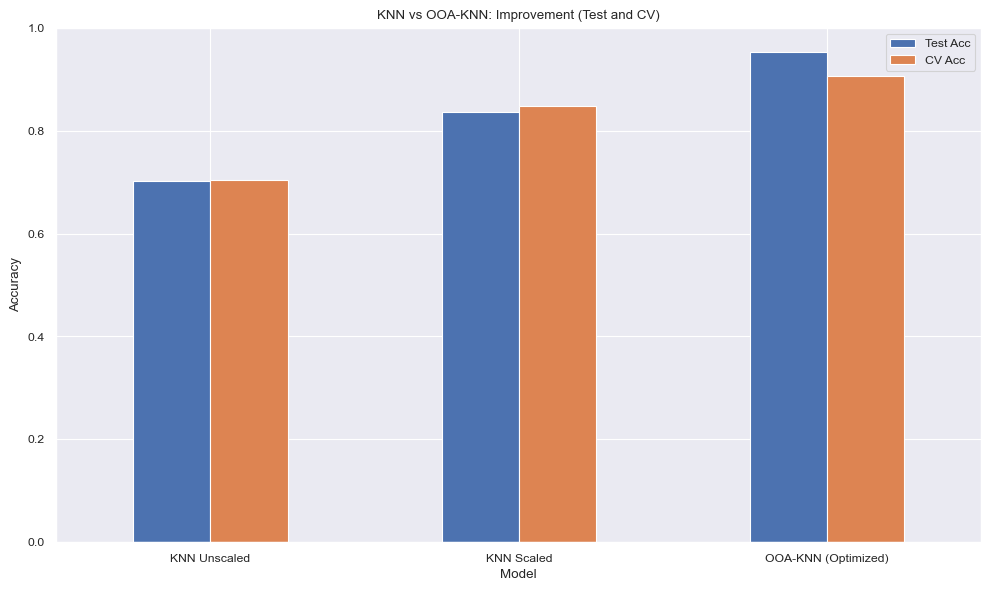

In [22]:
sns.set_theme('paper')
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar', figsize=(10,6))
plt.title('KNN vs OOA-KNN: Improvement (Test and CV)')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.savefig('../results/performance_comparision.png', dpi=300)
plt.show()

In [120]:
joblib.dump(knn_opt, '../models/ooa_knn_model.pkl')

['../models/ooa_knn_model.pkl']